In [1]:
import numpy as np
import matplotlib.pyplot as plt
from local_framework import local_framework
from population_framework import population_framework

In [2]:
# 2D random
# simulation length
NT = 3
# dt
dt_stim = 0.1/1000 
# time vector
time = np.arange(dt_stim, NT + dt_stim, dt_stim) 
# num time bins
nt = len(time) 

In [3]:
# create the stimulus\n
blocksize = 0.2  # length of stimulus blocks in sec
nblock = round((blocksize / dt_stim))  # number of blocks in simulation
stimrnge = [-25, 25]  # range of stimulus y values
stim1 = np.reshape(np.ones((nblock, 1)) * np.random.rand(1, nt // nblock), -1, order='F')  # generate random stimulus in 1D
stim1 = stim1 * np.diff(stimrnge) + stimrnge[0]  # shift to have desired range\n",
stim2 = np.reshape(np.ones((nblock, 1)) * np.random.rand(1, nt // nblock), -1, order='F')  # generate random stimulus in 1D
stim2 = stim2 * np.diff(stimrnge) + stimrnge[0]  # shift to have desired range
stim = np.vstack((stim1 - 0.5, -stim2 + 0.5))  # join both vectors into a 2-d stimulus


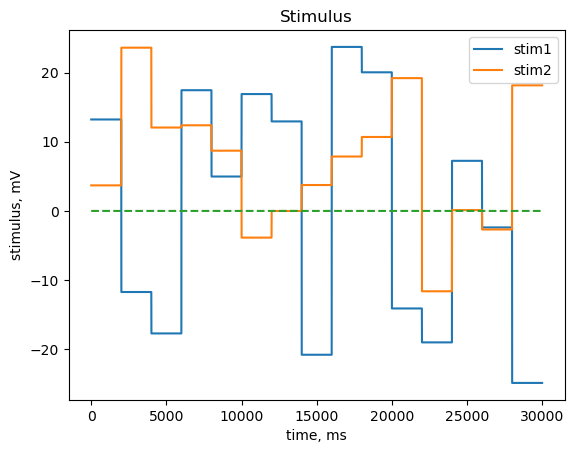

In [4]:
# plot stimulus
plt.plot(stim[0], label='stim1')
plt.plot(stim[1], label='stim2')

plt.plot(np.zeros(len(time)), '--')
plt.ylabel("stimulus, mV")
plt.xlabel("time, ms")
plt.title("Stimulus")
plt.legend()
plt.show()

In [17]:
# parameters for the simulation

# parameters for stimulation 1, 1D integrator
params_1 = {}
params_1["N"] = 400
params_1["tau_d"] = 1  
params_1["mu"] = 0  
params_1["time_delay"] = 0  
params_1["w_sig"] = 0.1 
# for local framework
params_1["F_max"] = 100 
params_1["alpha"] = 80  
params_1["F_min"] = 0  
# for population framework
params_1["beta"] = 50 
params_1["A"] = np.zeros((1,1))
params_1["w_mean"] = 0.1 * np.ones((1, params_1["A"].shape[0]))

# parameters for simulation 2, 2D harmonic oscillator
params_2 = {}
params_2["N"] = 400
params_2["tau_d"] = 1  
params_2["mu"] = 0  
params_2["time_delay"] = 0  
params_2["w_sig"] = 0.1  
# for local framework
params_2["F_max"] = 100
params_2["alpha"] = 80  
params_2["F_min"] = 0 
# for population framework
params_2["beta"] = 50 
params_2["A"] = np.linalg.inv(np.array([[-0.01, -0.1], [0.1, -0.01]]))
params_2["w_mean"] = 0.1 * np.ones((1, params_2["A"].shape[0])) 

print(params_1)
print(params_2)

{'N': 400, 'tau_d': 1, 'mu': 0, 'time_delay': 0, 'w_sig': 0.1, 'F_max': 100, 'alpha': 80, 'F_min': 0, 'beta': 50, 'A': array([[0.]]), 'w_mean': array([[0.1]])}
{'N': 400, 'tau_d': 1, 'mu': 0, 'time_delay': 0, 'w_sig': 0.1, 'F_max': 100, 'alpha': 80, 'F_min': 0, 'beta': 50, 'A': array([[-0.99009901,  9.9009901 ],
       [-9.9009901 , -0.99009901]]), 'w_mean': array([[0.1, 0.1]])}


In [18]:
# 1D
ss_l_1, xh_l_1, xx_l_1 = local_framework(stim = stim[1:, :], dt = dt_stim, params = params_1)
ss_p_1, xh_p_1, xx_p_1 = population_framework(stim = stim[1:, :], dt = dt_stim, params = params_1)

# 2D
ss_l_2, xh_l_2, xx_l_2 = local_framework(stim = stim, dt = dt_stim, params = params_2)
ss_p_2, xh_p_2, xx_p_2 = population_framework(stim = stim, dt = dt_stim, params = params_2)

In [19]:
def return_spiked_neurons_indices(ss, N):
    # inhibitory spikes
    ind_inh = np.argwhere(ss[1:int(N/2) + 1,:])
    i_inh = ind_inh[:,0] 
    j_inh = ind_inh[:,1]

    # excitatory spikes
    ind_exc = np.argwhere(ss[int(N/2):N,:])
    i_exc = ind_exc[:,0]
    j_exc = ind_exc[:,1]

    i_exc += 200 # to have a nice layout of the plot, otherwise excitatory spikes will be mixed with inhibitory ones

    return i_inh, j_inh, i_exc, j_exc 

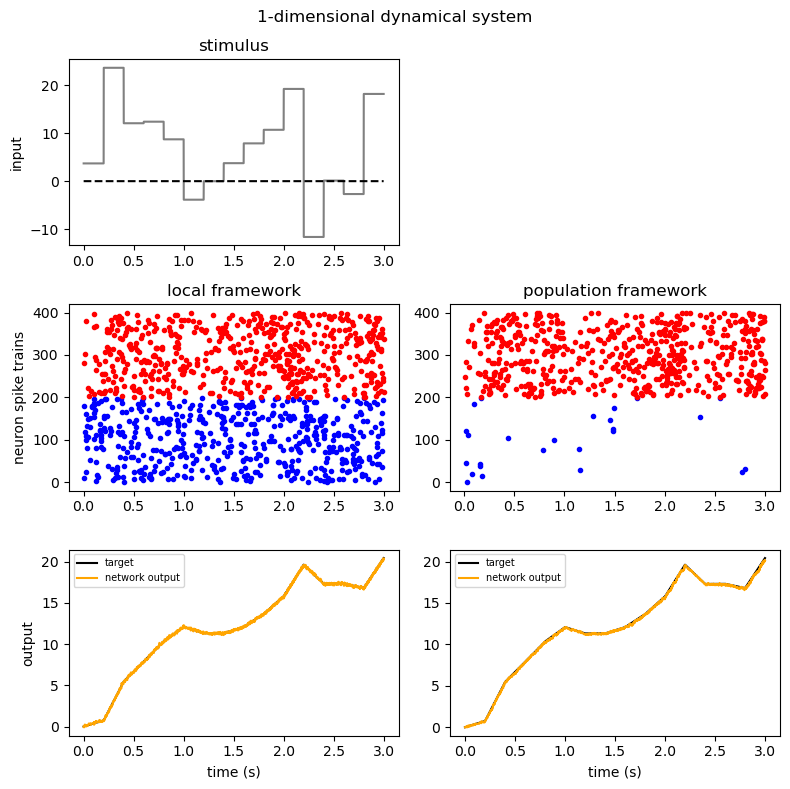

In [30]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
fig.delaxes(axes[0, 1])

axes[0, 0].plot(time, stim[1], c = "grey")
axes[0, 0].plot(time, np.zeros(len(time)), "--", c = "black")
axes[0, 0].set_title(r"stimulus")
axes[0, 0].set_ylabel("input")

# Raster plots of inh/exc spikes
i_inh_1, j_inh_1, i_exc_1, j_exc_1 = return_spiked_neurons_indices(ss_l_1, params_1["N"])
axes[1, 0].plot(j_inh_1 * dt_stim, i_inh_1, ".", c = "blue")
axes[1, 0].plot(j_exc_1 * dt_stim, i_exc_1, ".", c = "red")
axes[1, 0].set_title(r"local framework")
axes[1, 0].set_ylabel("neuron spike trains")

i_inh_2, j_inh_2, i_exc_2, j_exc_2 = return_spiked_neurons_indices(ss_p_1.squeeze(), params_1["N"])
axes[1, 1].plot(j_inh_2 * dt_stim, i_inh_2, ".", c = "blue")
axes[1, 1].plot(j_exc_2 * dt_stim, i_exc_2, ".", c = "red")
axes[1, 1].set_title(r"population framework")


# Plots of the target dynamics and our approximation
axes[2, 0].plot(time, xx_l_1.flatten(), c = "black", label = "target")
axes[2, 0].plot(time, xh_l_1.flatten(), "-", c = "orange", label = "network output")
axes[2, 0].legend(fontsize=7)
axes[2, 0].set_xlabel("time (s)")
axes[2, 0].set_ylabel("output")

axes[2, 1].plot(time, xx_p_1.flatten(), c = "black", label = "target")
axes[2, 1].plot(time, xh_p_1.flatten(), "-", c = "orange", label = "network output")
axes[2, 1].legend(fontsize=7)
axes[2, 1].set_xlabel("time (s)")




plt.suptitle("1-dimensional dynamical system")
plt.tight_layout()
plt.show()

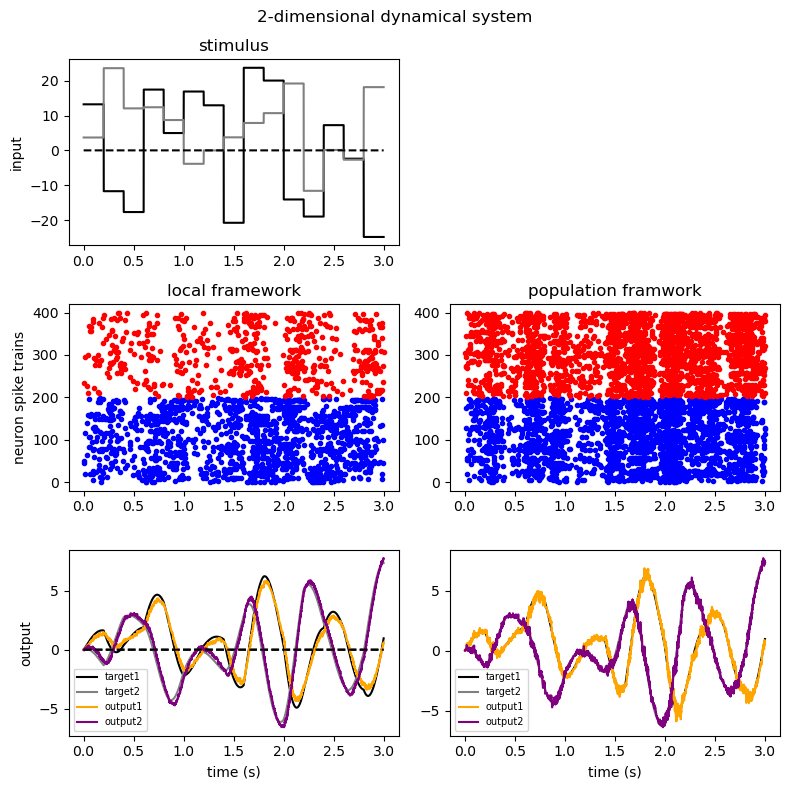

In [21]:
fig, axes = plt.subplots(3, 2, figsize=(8, 8))
fig.delaxes(axes[0, 1])


axes[0, 0].plot(time, stim[0], c = "black")
axes[0, 0].plot(time, stim[1], c = "grey")
axes[0, 0].plot(time, np.zeros(len(time)), "--", c = "black")
axes[0, 0].set_title(r"stimulus")
axes[0, 0].set_ylabel("input")


i_inh_3, j_inh_3, i_exc_3, j_exc_3 = return_spiked_neurons_indices(ss_l_2, params_2["N"])
axes[1, 0].plot(j_inh_3 * dt_stim, i_inh_3, ".", c = "blue")
axes[1, 0].plot(j_exc_3 * dt_stim, i_exc_3, ".", c = "red")
axes[1, 0].set_title(r"local framework")
axes[1, 0].set_ylabel("neuron spike trains")

i_inh_4, j_inh_4, i_exc_4, j_exc_4 = return_spiked_neurons_indices(ss_p_2.squeeze(), params_2["N"])
axes[1, 1].plot(j_inh_4 * dt_stim, i_inh_4, ".", c = "blue")
axes[1, 1].plot(j_exc_4 * dt_stim, i_exc_4, ".", c = "red")
axes[1, 1].set_title(r"population framwork")

axes[2, 0].plot(time, np.zeros(len(time)), "--", c = "black")
axes[2, 0].plot(time, xx_l_2[0], c = "black", label = "target1")
axes[2, 0].plot(time, xx_l_2[1], c = "grey", label = "target2")
axes[2, 0].plot(time, xh_l_2[0], "-", c = "orange", label = "output1")
axes[2, 0].plot(time, xh_l_2[1], "-", c = "purple", label = "output2")
axes[2, 0].set_xlabel("time (s)")
axes[2, 0].set_ylabel("output")
axes[2, 0].legend(fontsize=7)

axes[2, 0].plot(time, np.zeros(len(time)), "--", c = "black")
axes[2, 1].plot(time, xx_p_2[0], c = "black", label = "target1")
axes[2, 1].plot(time, xx_p_2[1], c = "grey", label = "target2")
axes[2, 1].plot(time, xh_p_2[0], "-", c = "orange", label = "output1")
axes[2, 1].plot(time, xh_p_2[1], "-", c = "purple", label = "output2")
axes[2, 1].set_xlabel("time (s)")
axes[2, 1].legend(fontsize=7)


plt.suptitle("2-dimensional dynamical system")
plt.tight_layout()
plt.show()